In [24]:
import pandas as pd
import os
import sys

project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.append(project_root)

from utils.cmod5n import cmod5n_forward, cmod5n_inverse
from utils.functions import *

import xarray as xr
from glob import glob

In [25]:
df1 = pd.read_parquet("../processed_data/wv1_complete.parquet")
df2 = pd.read_parquet("../processed_data/wv2_complete.parquet")

df1 = create_phi_bins_columns(df1, 'phi_nominal_median', 1)
df2 = create_phi_bins_columns(df2, 'phi_nominal_median', 1)

df1r = pd.read_parquet("../results_15_May/wv1_results_updated.parquet")
df2r = pd.read_parquet("../results_15_May/wv2_results_updated.parquet")

df1w = pd.read_parquet("../results_22_May/wv1_wind_results.parquet")
df2w = pd.read_parquet("../results_22_May/wv2_wind_results.parquet")

df1r["renamed_filename"] = df1r.sar_filepath.apply(lambda x: x.split("/")[-1])
df2r["renamed_filename"] = df2r.sar_filepath.apply(lambda x: x.split("/")[-1])

df1w["renamed_filename"] = df1w.sar_filepath.apply(lambda x: x.split("/")[-1])
df2w["renamed_filename"] = df2w.sar_filepath.apply(lambda x: x.split("/")[-1])

idxmax = df1w.k_values_wind.apply(lambda x: len(x)).argmax()
max_len = df1w.k_values_wind.apply(lambda x: len(x)).max()

df1r = pad_arrays_to_max_length(df1r, 'radial_psd', max_len)
df2r = pad_arrays_to_max_length(df2r, 'radial_psd', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_wind_psd', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_wind_psd', max_len)

In [26]:
df1w['b0'] = df1w.b0.apply(lambda x: clean_stats(x))
df1w['b1'] = df1w.b1.apply(lambda x: clean_stats(x))
df1w['b2'] = df1w.b2.apply(lambda x: clean_stats(x))

df2w['b0'] = df2w.b0.apply(lambda x: clean_stats(x))
df2w['b1'] = df2w.b1.apply(lambda x: clean_stats(x))
df2w['b2'] = df2w.b2.apply(lambda x: clean_stats(x))

In [4]:
k_values = get_k_values(df1r, "k_values")
k_values = k_values/20

In [5]:
# df1_rg, df1r_rg, df1w_rg = create_dfs_from_phi_interval('[-90, -89)', df1, df1r, df1w)
# df2_rg, df2r_rg, df2w_rg = create_dfs_from_phi_interval('[-90, -89)', df2, df2r, df2w)

In [6]:
# plot_avg_spectral_density(k_values, [df2w_rg, df1w_rg], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                           "Average Wind PSD", 
#                           x_range=(0.0001, 0.15), y_range=(0, 0.5e8), 
#                           use_log_scale=False, wavelength=True, bootstrap=True);

In [27]:
df1w['phi'] = df1r.phi_nominal.copy()
df2w['phi'] = df2r.phi_nominal.copy()

In [28]:
df1w = create_phi_bins_columns(df1w, 'phi', 30)
df2w = create_phi_bins_columns(df2w, 'phi', 30)

In [29]:
df1w.drop(columns=['phi_bin_centers'], inplace=True)
df2w.drop(columns=['phi_bin_centers'], inplace=True)

In [30]:
df1w['mean_b2'] = df1w['b2'].apply(lambda x: get_mean(x))
df2w['mean_b2'] = df2w['b2'].apply(lambda x: get_mean(x))

In [31]:
df1_b2 = df1w[['mean_b2', 'phi_bins']].copy()
df2_b2 = df2w[['mean_b2', 'phi_bins']].copy()

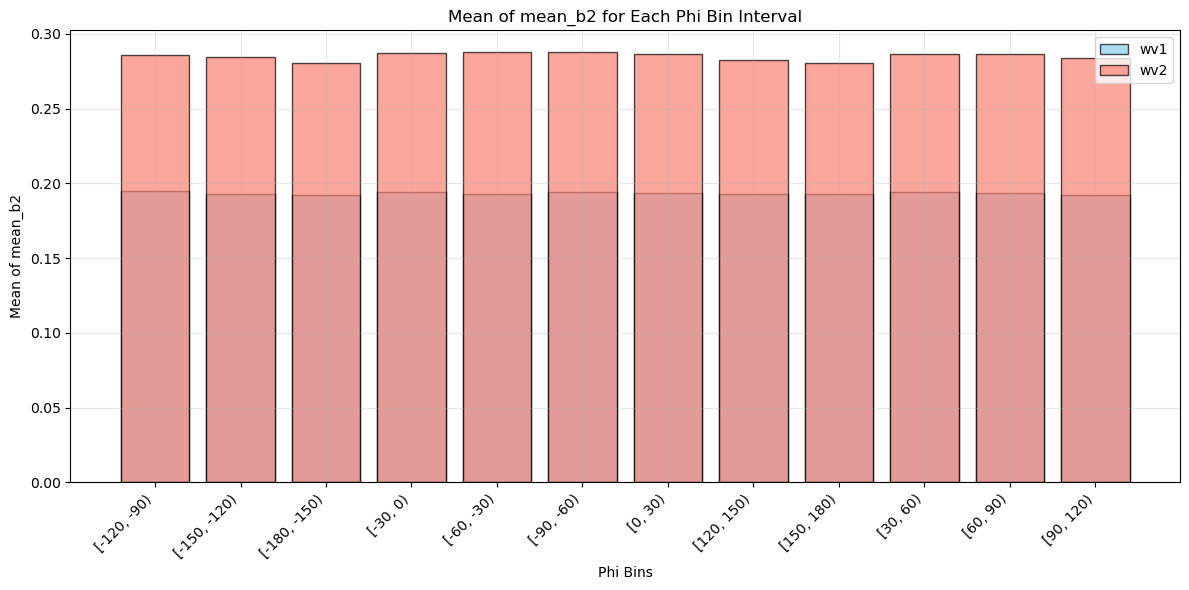

Mean of mean_b2 for each phi bin for WV1:
[-120, -90): 0.194739
[-150, -120): 0.192755
[-180, -150): 0.192500
[-30, 0): 0.194233
[-60, -30): 0.192847
[-90, -60): 0.194061
[0, 30): 0.193283
[120, 150): 0.192913
[150, 180): 0.192661
[30, 60): 0.194283
[60, 90): 0.193731
[90, 120): 0.192106

Mean of mean_b2 for each phi bin for WV2:
[-120, -90): 0.285546
[-150, -120): 0.284428
[-180, -150): 0.280603
[-30, 0): 0.287161
[-60, -30): 0.287833
[-90, -60): 0.287924
[0, 30): 0.286584
[120, 150): 0.282489
[150, 180): 0.280762
[30, 60): 0.286593
[60, 90): 0.286200
[90, 120): 0.283681


In [32]:
# Group by phi_bins and calculate the mean of mean_b2 for each bin
grouped_means1 = df1_b2.groupby('phi_bins')['mean_b2'].mean()
grouped_means2 = df2_b2.groupby('phi_bins')['mean_b2'].mean()

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(grouped_means1)), grouped_means1.values, alpha=0.7, color='skyblue', edgecolor='black',
        label="wv1")
plt.bar(range(len(grouped_means2)), grouped_means2.values, alpha=0.7, color='salmon', edgecolor='black',
        label="wv2")
# Set x-axis labels to show the phi bin intervals
plt.xticks(range(len(grouped_means1)), grouped_means1.index, rotation=45, ha='right')
plt.xlabel('Phi Bins')
plt.ylabel('Mean of mean_b2')
plt.title('Mean of mean_b2 for Each Phi Bin Interval')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print the results as well
print("Mean of mean_b2 for each phi bin for WV1:")
for bin_interval, mean_value in grouped_means1.items():
    print(f"{bin_interval}: {mean_value:.6f}")

print("\nMean of mean_b2 for each phi bin for WV2:")
for bin_interval, mean_value in grouped_means2.items():
    print(f"{bin_interval}: {mean_value:.6f}")


In [33]:
grouped_means_psd1 = df1w.groupby('phi_bins')['radial_wind_psd_padded'].mean()
grouped_means_psd2 = df2w.groupby('phi_bins')['radial_wind_psd_padded'].mean()

In [34]:
epsilon = 1e-10  # or any small number you prefer
psd_ratio = (grouped_means_psd1 + epsilon) / (grouped_means_psd2 + epsilon)
b2_mean_ratio = grouped_means1 / grouped_means2

In [35]:
def analyze_b_parameter_vs_psd(b_param_ratio, psd_ratio, k_values, param_name):
    """
    Analyze correlation between B-parameter ratio and PSD ratio across wavelengths.
    
    Parameters:
    -----------
    b_param_ratio : array-like
        Ratio of B-parameter (WV1/WV2) for each phi bin
    psd_ratio : DataFrame or array-like
        PSD ratios for each phi bin (rows) and wavelength (columns)
    k_values : array-like
        Wavenumber values
    param_name : str
        Name of the B-parameter for plotting (e.g., 'B0', 'B1', 'B2')
    """
    correlations = []
    wavelengths = 1/k_values
    
    for i in range(len(wavelengths)):
        psd_at_wavelength = [psd_ratio.iloc[j][i] for j in range(len(psd_ratio))]
        corr = np.corrcoef(b_param_ratio, psd_at_wavelength)[0,1]
        correlations.append(corr)
    
    plt.figure(figsize=(10, 6))
    plt.semilogx(wavelengths, correlations)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Wavelength [m]')
    plt.ylabel(f'Correlation({param_name}_ratio, PSD_ratio)')
    plt.title(f'{param_name} vs PSD Correlation Across Scales')
    plt.grid(True, alpha=0.3)
    
    return correlations, wavelengths

def analyze_cos2phi_correlation(
    psd_ratio, 
    phi_bins, 
    k_values, 
    test_wavelengths=[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
    ax=None,
    label=None
):
    """
    Analyze PSD correlation with cos(2φ) pattern across different wavelengths.

    Parameters:
    -----------
    psd_ratio : DataFrame or array-like
        PSD ratios for each phi bin (rows) and wavelength (columns)
    phi_bins : array-like
        Phi bin labels (e.g., ['[-180, -150)', ...])
    k_values : array-like
        Wavenumber values
    test_wavelengths : list
        Wavelengths to test correlation at
    ax : matplotlib axis, optional
        Axis to plot on. If None, a new figure is created.
    """
    wavelengths = 1/k_values

    # Calculate phi centers and cos(2φ)
    phi_centers = np.array([float(bin.split(',')[0].strip('()[]')) + 15 for bin in phi_bins])
    cos_2phi = np.cos(2 * np.radians(phi_centers))

    # Calculate correlations at test wavelengths
    psd_cos2phi_correlations = []

    for target_wl in test_wavelengths:
        wl_idx = np.argmin(np.abs(wavelengths - target_wl))
        psd_at_wl = [psd_ratio.iloc[j][wl_idx] for j in range(len(psd_ratio))]
        corr = np.corrcoef(psd_at_wl, cos_2phi)[0,1]
        psd_cos2phi_correlations.append(corr)
        print(f"PSD ratio at {target_wl}m vs cos(2φ) correlation: {corr:.3f}")

    # Plot correlation vs wavelength
    # if ax is None:
    #     fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(test_wavelengths, psd_cos2phi_correlations, 'o-', linewidth=2, markersize=8, label=label)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Wavelength [m]')
    ax.set_ylabel('Correlation with cos(2φ)')
    ax.set_title('PSD vs cos(2φ) Correlation')
    plt.legend()
    ax.grid(True, alpha=0.3)

    return psd_cos2phi_correlations, cos_2phi, phi_centers


In [36]:
df1w['mean_b1'] = df1w['b1'].apply(lambda x: get_mean(x))
df2w['mean_b1'] = df2w['b1'].apply(lambda x: get_mean(x))

df1w['mean_b0'] = df1w['b0'].apply(lambda x: get_mean(x))
df2w['mean_b0'] = df2w['b0'].apply(lambda x: get_mean(x))

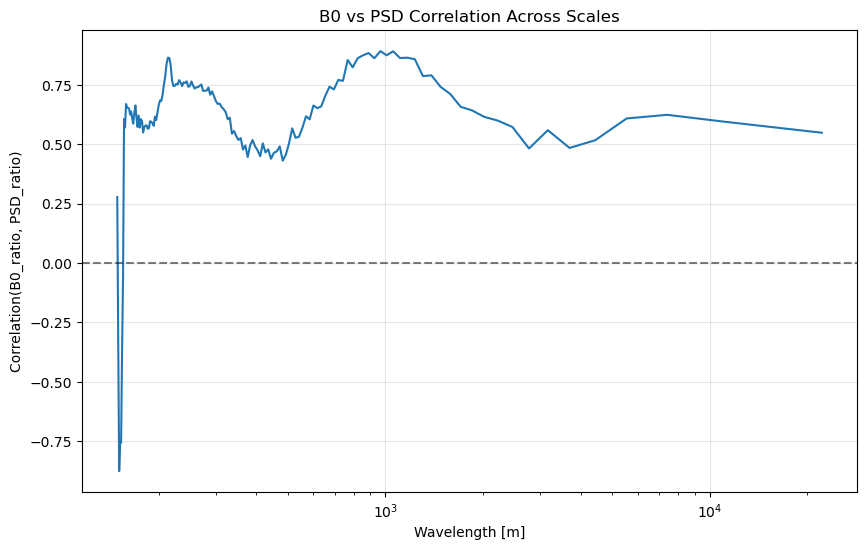

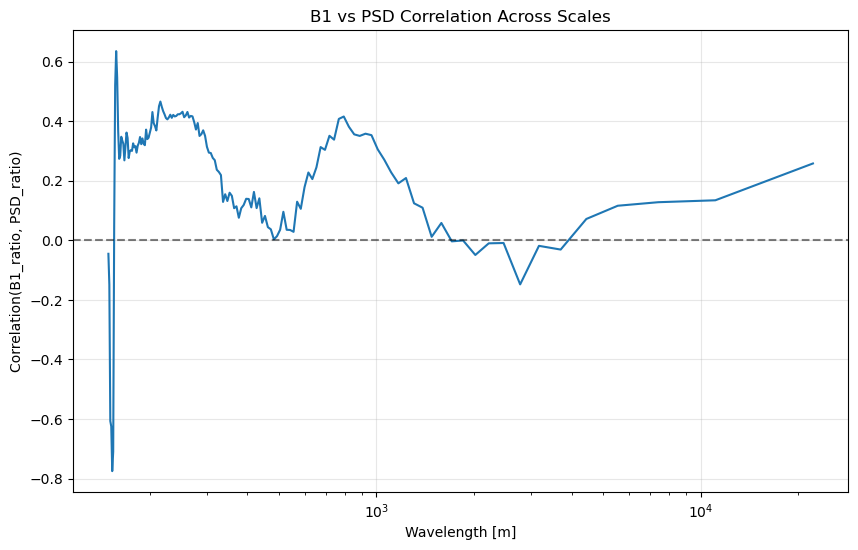

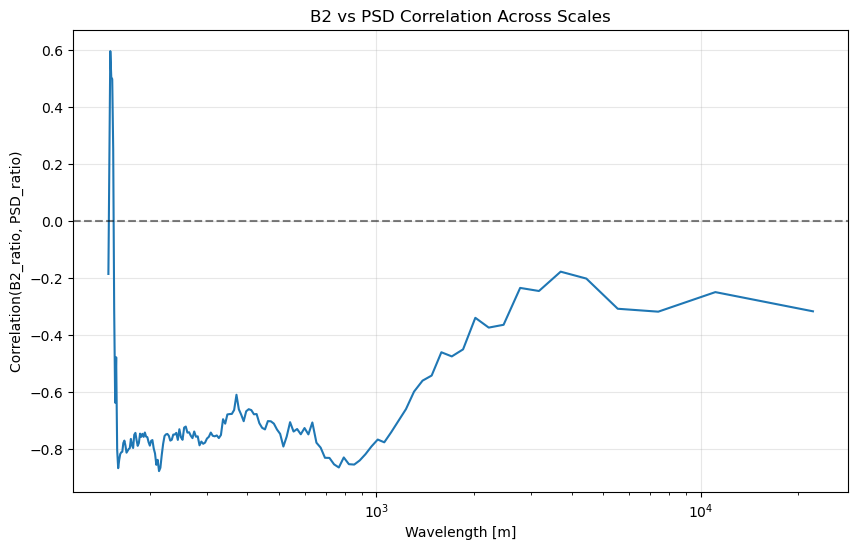

In [41]:
b0_mean_ratio = df1w.groupby('phi_bins')['mean_b0'].mean() / df2w.groupby('phi_bins')['mean_b0'].mean()
b1_mean_ratio = df1w.groupby('phi_bins')['mean_b1'].mean() / df2w.groupby('phi_bins')['mean_b1'].mean()

b0_correlations, wavelengths = analyze_b_parameter_vs_psd(b0_mean_ratio, psd_ratio, k_values, 'B0');
b1_correlations, wavelengths = analyze_b_parameter_vs_psd(b1_mean_ratio, psd_ratio, k_values, 'B1');
b2_correlations, wavelengths = analyze_b_parameter_vs_psd(b2_mean_ratio, psd_ratio, k_values, 'B2');


In [40]:
b0_mean_wv1 = df1w.groupby('phi_bins')['mean_b0'].mean()
b1_mean_wv1 = df1w.groupby('phi_bins')['mean_b1'].mean()
b2_mean_wv1 = df1w.groupby('phi_bins')['mean_b2'].mean()

b0_mean_wv2 = df2w.groupby('phi_bins')['mean_b0'].mean()
b1_mean_wv2 = df2w.groupby('phi_bins')['mean_b1'].mean()
b2_mean_wv2 = df2w.groupby('phi_bins')['mean_b2'].mean()

# b0_correlations, wavelengths = analyze_b_parameter_vs_psd(b0_mean_wv1, grouped_means_psd1, k_values, 'B0w')
# b1_correlations, wavelengths = analyze_b_parameter_vs_psd(b1_mean_wv1, grouped_means_psd1, k_values, 'B1')
# b2_correlations, wavelengths = analyze_b_parameter_vs_psd(b2_mean_wv1, grouped_means_psd1, k_values, 'B2')

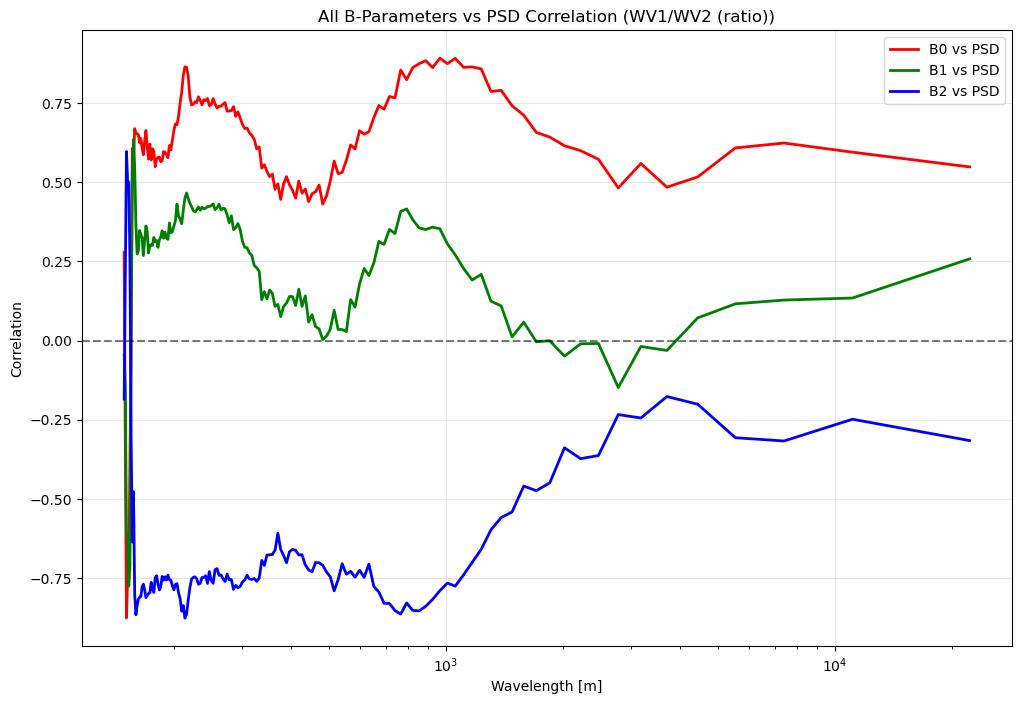

In [42]:
# Plot all three on the same figure
fig, ax = plt.subplots(figsize=(12, 8))
ax.semilogx(wavelengths, b0_correlations, 'r-', label='B0 vs PSD', linewidth=2)
ax.semilogx(wavelengths, b1_correlations, 'g-', label='B1 vs PSD', linewidth=2)
ax.semilogx(wavelengths, b2_correlations, 'b-', label='B2 vs PSD', linewidth=2)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Wavelength [m]')
ax.set_ylabel('Correlation')
ax.set_title('All B-Parameters vs PSD Correlation (WV1/WV2 (ratio))')
ax.legend()
ax.grid(True, alpha=0.3)

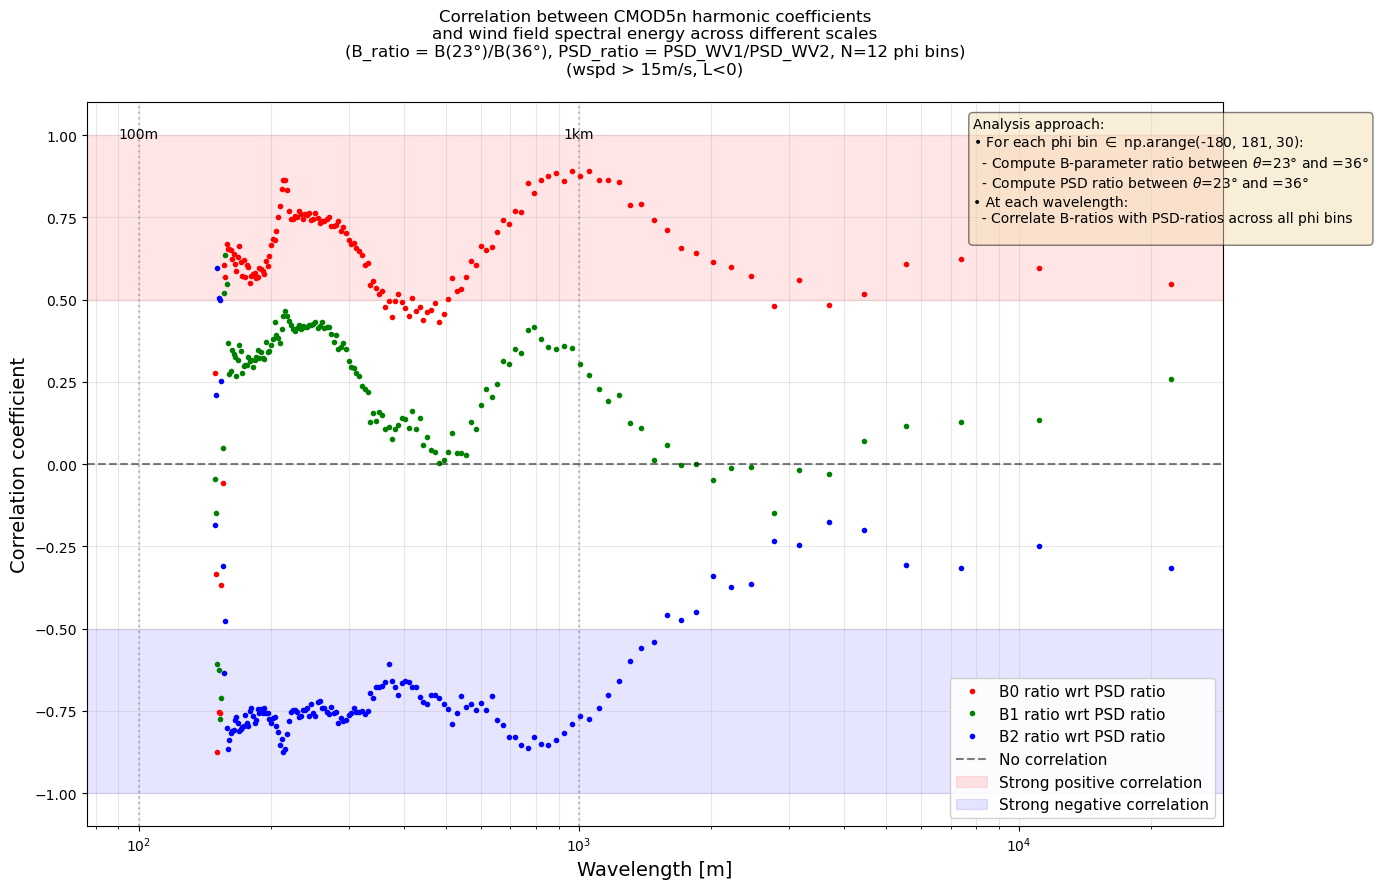

In [43]:
# Create figure with better explanation
fig, ax = plt.subplots(figsize=(14, 9))

# Plot correlations
ax.semilogx(wavelengths, b0_correlations, 'r.', label='B0 ratio wrt PSD ratio', linewidth=2.5)
ax.semilogx(wavelengths, b1_correlations, 'g.', label='B1 ratio wrt PSD ratio', linewidth=2.5)
ax.semilogx(wavelengths, b2_correlations, 'b.', label='B2 ratio wrt PSD ratio', linewidth=2.5)

# Add reference line
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='No correlation')

# Add shaded regions for interpretation
ax.axhspan(0.5, 1.0, alpha=0.1, color='red', label='Strong positive correlation')
ax.axhspan(-1.0, -0.5, alpha=0.1, color='blue', label='Strong negative correlation')

# Labels and title
ax.set_xlabel('Wavelength [m]', fontsize=14)
ax.set_ylabel('Correlation coefficient', fontsize=14)

# More descriptive title
title = ('Correlation between CMOD5n harmonic coefficients\n'
         'and wind field spectral energy across different scales\n'
         f'(B_ratio = B(23°)/B(36°), PSD_ratio = PSD_WV1/PSD_WV2, N={len(b0_mean_ratio)} phi bins)\n'
         '(wspd > 15m/s, L<0)')
ax.set_title(title, fontsize=12, pad=20)

# Add text box explaining the analysis
textstr = ('Analysis approach:\n'
           '• For each phi bin $\in$ np.arange(-180, 181, 30):\n'
           '  - Compute B-parameter ratio between $\\theta$=23° and =36°\n'
           '  - Compute PSD ratio between $\\theta$=23° and =36°\n'
           '• At each wavelength:\n'
           '  - Correlate B-ratios with PSD-ratios across all phi bins\n')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.78, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# Improved legend
ax.legend(loc='lower right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, which='both')

# Add vertical lines for key wavelengths
ax.axvline(x=100, color='gray', linestyle=':', alpha=0.5)
ax.text(100, ax.get_ylim()[1]*0.9, '100m', ha='center', fontsize=10)
ax.axvline(x=1000, color='gray', linestyle=':', alpha=0.5)
ax.text(1000, ax.get_ylim()[1]*0.9, '1km', ha='center', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

# Add a second plot showing what the ratios mean
# fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# plt.tight_layout()
# plt.show()

In [44]:
df1.iloc[0].lonlat_center

'-145.681915718 44.0278263401'

NameError: name 'phi_bins' is not defined

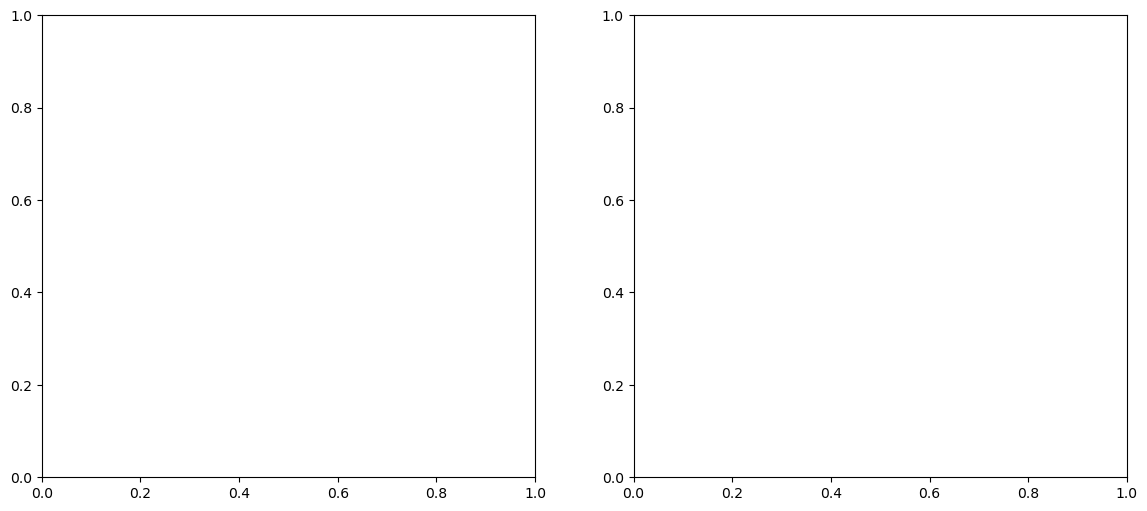

In [45]:
def analyze_cosφ_correlation(
    psd_ratio, 
    phi_bins, 
    k_values, 
    test_wavelengths=[2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
    ax=None,
    label=None
):
    """Analyze PSD correlation with cos(φ) pattern - for B1 effects.
    
    If ax is provided, plot on that axis. Otherwise, create a new figure.
    """
    wavelengths = 1/k_values
    phi_centers = np.array([float(bin.split(',')[0].strip('()[]')) + 15 for bin in phi_bins])
    cos_phi = np.cos(np.radians(phi_centers))  # cos(φ), not cos(2φ)
    
    psd_cosphi_correlations = []
    
    for target_wl in test_wavelengths:
        wl_idx = np.argmin(np.abs(wavelengths - target_wl))
        psd_at_wl = [psd_ratio.iloc[j][wl_idx] for j in range(len(psd_ratio))]
        corr = np.corrcoef(psd_at_wl, cos_phi)[0,1]
        psd_cosphi_correlations.append(corr)
        print(f"PSD ratio at {target_wl}m vs cos(φ) correlation: {corr:.3f}")
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(test_wavelengths, psd_cosphi_correlations, 'o-', linewidth=2, markersize=8, label=label)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Wavelength [m]')
    ax.set_ylabel('Correlation with cos(φ)')
    ax.set_title('PSD vs cos(φ) Correlation')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return psd_cosphi_correlations

_, axes = plt.subplots(1, 2, figsize=(14, 6))

b1_cosphi_corr = analyze_cosφ_correlation(grouped_means_psd1, phi_bins, k_values, ax=axes[0], label="wv1")
b1_cosphi_corr = analyze_cosφ_correlation(grouped_means_psd2, phi_bins, k_values, ax=axes[0], label="wv2")
psd_cos2phi_corr, cos_2phi, phi_centers = analyze_cos2phi_correlation(grouped_means_psd1, phi_bins, k_values, ax=axes[1], label='wv1')
psd_cos2phi_corr, cos_2phi, phi_centers = analyze_cos2phi_correlation(grouped_means_psd2, phi_bins, k_values, ax=axes[1], label='wv2')

In [256]:
df1

,value,wm_type,lonlat_center,tif_path,process_status,class_1,prob_1,class_2,prob_2,class_3,...,band1_rel_error_mean,band1_rmse,band2_wspd_mean,band2_wspd_median,band2_error_mean,band2_error_median,band2_abs_error_mean,band2_rel_error_mean,band2_rmse,phi_bins
172,15,wv1,-145.681915718 44.0278263401,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.997555,IB,0.001893,AF,...,-0.998634,15.851076,0.007545,-0.039062,-15.864844,-15.911452,15.864844,-0.999525,15.864996,"[-31, -30)"
174,17,wv1,-146.181079922 42.271247523,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.996547,IB,0.002811,AF,...,-0.998192,18.072377,0.011308,-0.039062,-18.093251,-18.143621,18.093251,-0.999375,18.093477,"[-24, -23)"
414,13,wv1,56.3452059747 -49.7595448547,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.998195,IB,0.001388,AF,...,-0.998580,16.646272,0.008547,-0.039062,-16.660978,-16.708588,16.660978,-0.999487,16.661149,"[9, 10)"
416,15,wv1,55.5013010377 -48.047256985,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.992784,IB,0.004895,AF,...,-0.998590,16.241238,0.008196,0.039062,-16.255560,-16.224694,16.255560,-0.999496,16.255734,"[10, 11)"
540,9,wv1,-101.674351923 -57.318909724,/home/datawork-cersat-public/cache/public/ftp/...,OK,WS,0.458845,POS,0.441267,IB,...,-0.998583,17.066595,0.008226,-0.039062,-17.082159,-17.129448,17.082159,-0.999519,17.082324,"[29, 30)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720624,47,wv1,-93.2433415386 -55.4957254597,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.995901,IB,0.003562,AF,...,-0.997995,17.682402,0.012178,-0.039062,-17.705056,-17.756297,17.705056,-0.999313,17.705317,"[-167, -166)"
720626,49,wv1,-94.3793017458 -57.1785945787,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.997312,IB,0.002251,AF,...,-0.998581,18.493757,0.008949,0.039062,-18.510628,-18.480515,18.510628,-0.999517,18.510804,"[-163, -162)"
720628,51,wv1,-95.6160799379 -58.8508025819,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.996666,IB,0.002510,AF,...,-0.998391,16.515762,0.009602,0.000000,-16.532262,-16.541864,16.532262,-0.999420,16.532463,"[-175, -174)"
720634,57,wv1,-100.129731802 -63.7831661238,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.976486,AF,0.015158,IB,...,-0.998839,16.607548,0.006440,0.039062,-16.620080,-16.587457,16.620080,-0.999613,16.620215,"[145, 146)"


In [ ]:
# d = compute_directional_differences(df1, df2, df1r, df2r, df1w, df2w, k_values, phi_res=1)
# plot_directional_differences(d, k_values, plot_type='wavelength', cmap='RdBu_r', 
#                              max_wavelength=100, vmin=-1e6, vmax=1e6)

Performing block bootstrap with 1040 samples, block size 32, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 885.77it/s]


Performing block bootstrap with 1132 samples, block size 33, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 852.04it/s]


Performing block bootstrap with 418 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 5436.28it/s]


Performing block bootstrap with 405 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 5451.20it/s]


Performing block bootstrap with 254 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 8631.91it/s]


Performing block bootstrap with 255 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 7591.72it/s]


Performing block bootstrap with 237 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 8405.52it/s]


Performing block bootstrap with 259 samples, block size 16, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 6118.76it/s]


Performing block bootstrap with 407 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 5312.40it/s]


Performing block bootstrap with 446 samples, block size 21, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4467.14it/s]


Performing block bootstrap with 1369 samples, block size 37, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 745.80it/s]


Performing block bootstrap with 1448 samples, block size 38, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 686.71it/s]


Performing block bootstrap with 2278 samples, block size 47, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 455.67it/s]


Performing block bootstrap with 2381 samples, block size 48, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 399.39it/s]


Performing block bootstrap with 1338 samples, block size 36, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 661.04it/s]


Performing block bootstrap with 1262 samples, block size 35, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 739.06it/s]


Performing block bootstrap with 541 samples, block size 23, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 1389.95it/s]


Performing block bootstrap with 518 samples, block size 22, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 1452.81it/s]


Performing block bootstrap with 641 samples, block size 25, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 1183.99it/s]


Performing block bootstrap with 542 samples, block size 23, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 2056.95it/s]


Performing block bootstrap with 1848 samples, block size 42, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 491.55it/s]


Performing block bootstrap with 1781 samples, block size 42, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 518.46it/s]


Performing block bootstrap with 2218 samples, block size 47, and 1000 replicates


100%|██████████| 1000/1000 [00:05<00:00, 173.88it/s]


Performing block bootstrap with 2171 samples, block size 46, and 1000 replicates


100%|██████████| 1000/1000 [00:05<00:00, 169.19it/s]


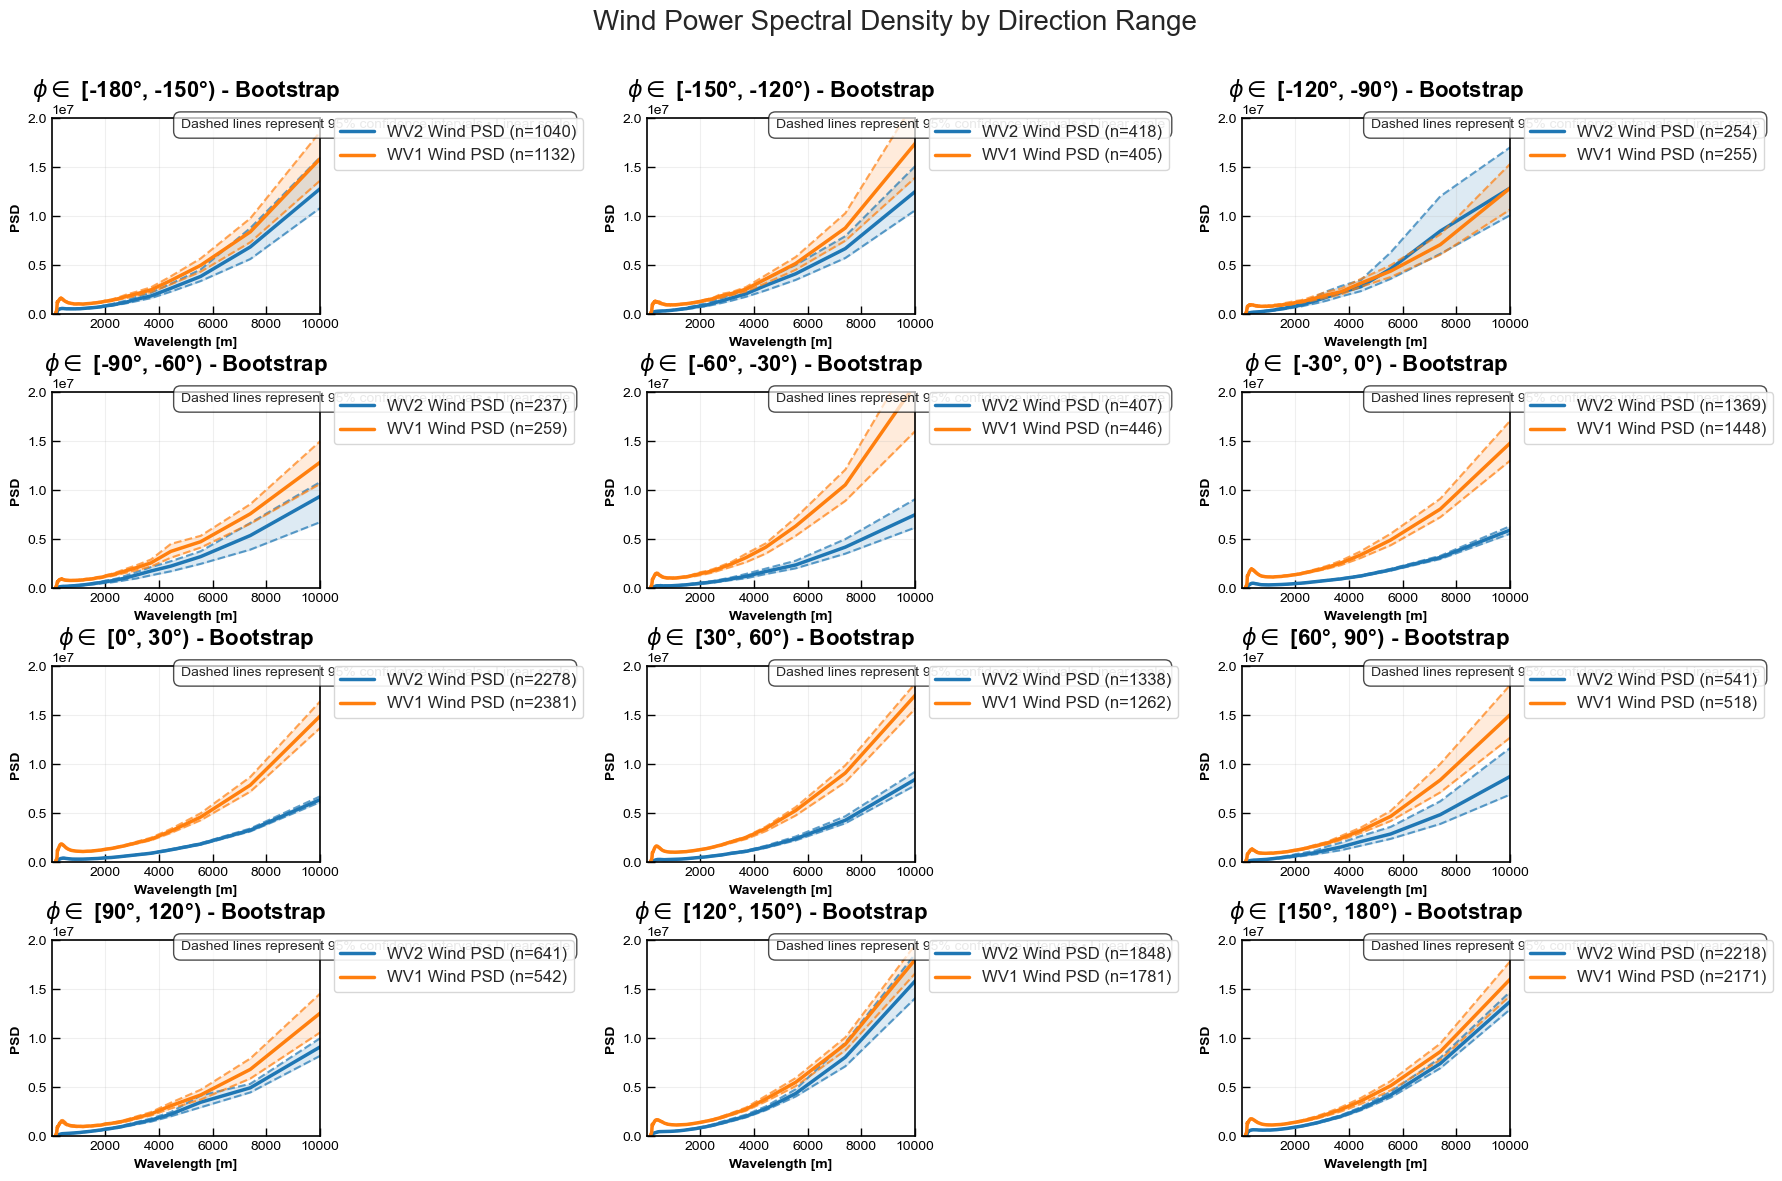

In [57]:
intervals = np.arange(-180, 181, 30)

# Create the figure and axes
fig, axes = plt.subplots(4, 3, figsize=(18, 12))

# Flatten the 2D array of axes
flat_axes = axes.flatten()

for i in range(len(intervals)-1):
    a = intervals[i]
    b = intervals[i+1]
    
    # Skip if we've run out of axes
    if i >= len(flat_axes):
        print(f"Warning: Not enough axes for interval {a} to {b}")
        continue
        
    # Get the current axis
    current_ax = flat_axes[i]
    
    # Construct filtered DataFrames for the current interval
    df1_filtered, df1r_filtered, df1w_filtered, df2_filtered, df2r_filtered, df2w_filtered = construct_df(a, b, df1, df1r, df1w, df2, df2r, df2w)
    df1_filtered = filter_similar_atmospheric_conditions(df1_filtered, L_range=(-1e6, -1000))
    df2_filtered = filter_similar_atmospheric_conditions(df2_filtered, L_range=(-1e6, -1000))

    df1r_filtered = df1r_filtered[df1r_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    df2r_filtered = df2r_filtered[df2r_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    df1w_filtered = df1w_filtered[df1w_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    df2w_filtered = df2w_filtered[df2w_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    # Plot on the current axis
    _, _ = plot_avg_spectral_density(k_values, [df2w_filtered, df1w_filtered],
                              ["WV2 Wind PSD", "WV1 Wind PSD"],
                              f"$\\phi \\in$ [{a}°, {b}°)", 
                              x_range=(0.0001, 0.15), y_range=(0, 0.2e8), 
                              use_log_scale=False, wavelength=True, bootstrap=True,
                              ax=current_ax)  

# Hide any unused axes
for j in range(i+1, len(flat_axes)):
    flat_axes[j].set_visible(False)

# Add a common title for the entire figure
fig.suptitle('Wind Power Spectral Density by Direction Range', fontsize=20, y=0.98)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # The rect parameter reserves space for the suptitle

# Show the figure
plt.show()

In [9]:
# df1_m180_m150, df1r_m180_m150, df1w_m180_m150, df2_m180_m150, df2r_m180_m150, df2w_m180_m150 = construct_df(-180, -150, df1, df1r, df1w, df2, df2r, df2w)
# df1_m150_m120, df1r_m150_m120, df1w_m150_m120, df2_m150_m120, df2r_m150_m120, df2w_m150_m120 = construct_df(-150, -120, df1, df1r, df1w, df2, df2r, df2w)
# df1_m120_m90, df1r_m120_m90, df1w_m120_m90, df2_m120_m90, df2r_m120_m90, df2w_m120_m90 = construct_df(-120, -90, df1, df1r, df1w, df2, df2r, df2w)
# df1_m90_m60, df1r_m90_m60, df1w_m90_m60, df2_m90_m60, df2r_m90_m60, df2w_m90_m60 = construct_df(-90, -60, df1, df1r, df1w, df2, df2r, df2w)
# df1_m60_m30, df1r_m60_m30, df1w_m60_m30, df2_m60_m30, df2r_m60_m30, df2w_m60_m30 = construct_df(-60, -30, df1, df1r, df1w, df2, df2r, df2w)
# df1_m30_0, df1r_m30_0, df1w_m30_0, df2_m30_0, df2r_m30_0, df2w_m30_0 = construct_df(-30, 0, df1, df1r, df1w, df2, df2r, df2w)
# df1_0_30, df1r_0_30, df1w_0_30, df2_0_30, df2r_0_30, df2w_0_30 = construct_df(0, 30, df1, df1r, df1w, df2, df2r, df2w)
# df1_30_60, df1r_30_60, df1w_30_60, df2_30_60, df2r_30_60, df2w_30_60 = construct_df(30, 60, df1, df1r, df1w, df2, df2r, df2w)
# df1_60_90, df1r_60_90, df1w_60_90, df2_60_90, df2r_60_90, df2w_60_90 = construct_df(60, 90, df1, df1r, df1w, df2, df2r, df2w)
# df1_90_120, df1r_90_120, df1w_90_120, df2_90_120, df2r_90_120, df2w_90_120 = construct_df(90, 120, df1, df1r, df1w, df2, df2r, df2w)
# df1_120_150, df1r_120_150, df1w_120_150, df2_120_150, df2r_120_150, df2w_120_150 = construct_df(120, 150, df1, df1r, df1w, df2, df2r, df2w)
# df1_150_180, df1r_150_180, df1w_150_180, df2_150_180, df2r_150_180, df2w_150_180 = construct_df(150, 180, df1, df1r, df1w, df2, df2r, df2w)

In [10]:
# df1_reconstructed = pd.concat([df1_m180_m150, df1_m150_m120, df1_m120_m90, df1_m90_m60, df1_m60_m30, df1_m30_0,
#                                df1_0_30, df1_30_60, df1_60_90, df1_90_120, df1_120_150, df1_150_180], ignore_index=True)

# df2_reconstructed = pd.concat([df2_m180_m150, df2_m150_m120, df2_m120_m90, df2_m90_m60, df2_m60_m30, df2_m30_0,
#                                  df2_0_30, df2_30_60, df2_60_90, df2_90_120, df2_120_150, df2_150_180], ignore_index=True)

In [11]:
# filtered_df1 = filter_similar_atmospheric_conditions(df1_reconstructed, L_range=(-1e6, -1000))
# filtered_df2 = filter_similar_atmospheric_conditions(df2_reconstructed, L_range=(-1e6, -1000))
# filtered_df1r = df1r[df1r["renamed_filename"].isin(filtered_df1["renamed_filename"])]
# filtered_df2r = df2r[df2r["renamed_filename"].isin(filtered_df2["renamed_filename"])]
# filtered_df1w = df1w[df1w["renamed_filename"].isin(filtered_df1["renamed_filename"])]
# filtered_df2w = df2w[df2w["renamed_filename"].isin(filtered_df2["renamed_filename"])]

# d = compute_directional_differences(filtered_df1, filtered_df2,
#                                     filtered_df1r, filtered_df2r, 
#                                     filtered_df1w, filtered_df2w, 
#                                     k_values=k_values, phi_res=30)

# plot_directional_differences(d, k_values, plot_type='wavelength', cmap='RdBu_r',
#                                 max_wavelength=120, vmin=-1e6, vmax=1e6,
#                                 title=f"Directional Differences - Filtered - L_range {(-1e6, -1000)}")

In [12]:
# # wspd_range = (18, 19)
# L_ranges = [(-1e6, -1000), (-1000, -500), (-500, 0)]
# ds = []
# for L_range in L_ranges:
#     filtered_df1 = filter_similar_atmospheric_conditions(df1, L_range=L_range)
#     filtered_df2 = filter_similar_atmospheric_conditions(df2, L_range=L_range)

#     filtered_df1r = df1r[df1r['renamed_filename'].isin(filtered_df1['renamed_filename'])]
#     filtered_df2r = df2r[df2r['renamed_filename'].isin(filtered_df2['renamed_filename'])]

#     filtered_df1w = df1w[df1w['renamed_filename'].isin(filtered_df1['renamed_filename'])]
#     filtered_df2w = df2w[df2w['renamed_filename'].isin(filtered_df2['renamed_filename'])]

#     filtered_df1_rg_uw = filter_similar_atmospheric_conditions(df1_rg_uw, L_range=L_range)
#     filtered_df2_rg_uw = filter_similar_atmospheric_conditions(df2_rg_uw, L_range=L_range)
#     filtered_df1r_rg_uw = df1r_rg_uw[df1r_rg_uw['renamed_filename'].isin(filtered_df1_rg_uw['renamed_filename'])]
#     filtered_df2r_rg_uw = df2r_rg_uw[df2r_rg_uw['renamed_filename'].isin(filtered_df2_rg_uw['renamed_filename'])]
#     filtered_df1w_rg_uw = df1w_rg_uw[df1w_rg_uw['renamed_filename'].isin(filtered_df1_rg_uw['renamed_filename'])]
#     filtered_df2w_rg_uw = df2w_rg_uw[df2w_rg_uw['renamed_filename'].isin(filtered_df2_rg_uw['renamed_filename'])]

#     filtered_df1_rg_dw = filter_similar_atmospheric_conditions(df1_rg_dw, L_range=L_range)
#     filtered_df2_rg_dw = filter_similar_atmospheric_conditions(df2_rg_dw, L_range=L_range)
#     filtered_df1r_rg_dw = df1r_rg_dw[df1r_rg_dw['renamed_filename'].isin(filtered_df1_rg_dw['renamed_filename'])]
#     filtered_df2r_rg_dw = df2r_rg_dw[df2r_rg_dw['renamed_filename'].isin(filtered_df2_rg_dw['renamed_filename'])]
#     filtered_df1w_rg_dw = df1w_rg_dw[df1w_rg_dw['renamed_filename'].isin(filtered_df1_rg_dw['renamed_filename'])]
#     filtered_df2w_rg_dw = df2w_rg_dw[df2w_rg_dw['renamed_filename'].isin(filtered_df2_rg_dw['renamed_filename'])]

#     filtered_df1_az_lr = filter_similar_atmospheric_conditions(df1_az_lr, L_range=L_range)
#     filtered_df2_az_lr = filter_similar_atmospheric_conditions(df2_az_lr, L_range=L_range)
#     filtered_df1r_az_lr = df1r_az_lr[df1r_az_lr['renamed_filename'].isin(filtered_df1_az_lr['renamed_filename'])]
#     filtered_df2r_az_lr = df2r_az_lr[df2r_az_lr['renamed_filename'].isin(filtered_df2_az_lr['renamed_filename'])]
#     filtered_df1w_az_lr = df1w_az_lr[df1w_az_lr['renamed_filename'].isin(filtered_df1_az_lr['renamed_filename'])]
#     filtered_df2w_az_lr = df2w_az_lr[df2w_az_lr['renamed_filename'].isin(filtered_df2_az_lr['renamed_filename'])]

#     filtered_df1_az_rl = filter_similar_atmospheric_conditions(df1_az_rl, L_range=L_range)
#     filtered_df2_az_rl = filter_similar_atmospheric_conditions(df2_az_rl, L_range=L_range)
#     filtered_df1r_az_rl = df1r_az_rl[df1r_az_rl['renamed_filename'].isin(filtered_df1_az_rl['renamed_filename'])]
#     filtered_df2r_az_rl = df2r_az_rl[df2r_az_rl['renamed_filename'].isin(filtered_df2_az_rl['renamed_filename'])]
#     filtered_df1w_az_rl = df1w_az_rl[df1w_az_rl['renamed_filename'].isin(filtered_df1_az_rl['renamed_filename'])]
#     filtered_df2w_az_rl = df2w_az_rl[df2w_az_rl['renamed_filename'].isin(filtered_df2_az_rl['renamed_filename'])]

#     plot_avg_spectral_density(k_values, [filtered_df2w_rg_uw, filtered_df1w_rg_uw], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - rg uw", 
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7), 
#                             use_log_scale=False, wavelength=True);

    
#     plot_avg_spectral_density(k_values, [filtered_df2w_rg_dw, filtered_df1w_rg_dw], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - rg dw",
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7),
#                             use_log_scale=False, wavelength=True);
    
#     plot_avg_spectral_density(k_values, [filtered_df2w_az_lr, filtered_df1w_az_lr], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - az lr",
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7),
#                             use_log_scale=False, wavelength=True);
    
#     plot_avg_spectral_density(k_values, [filtered_df2w_az_rl, filtered_df1w_az_rl], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - az rl",
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7),
#                             use_log_scale=False, wavelength=True);

#     d = compute_directional_differences(filtered_df1, filtered_df2,
#                                         filtered_df1r, filtered_df2r, 
#                                         filtered_df1w, filtered_df2w, 
#                                         k_values=k_values, phi_res=5)
    
#     plot_directional_differences(d, k_values, plot_type='wavelength', cmap='RdBu_r',
#                                  max_wavelength=120, vmin=-1e6, vmax=1e6,
#                                  title=f"Directional Differences - Filtered - L_range {L_range}")

In [13]:
# d = compute_directional_differences(df1, df2, df1r, df2r, df1w, df2w, k_values, phi_res=5)

In [14]:
# plot_directional_differences(d, k_values, plot_type='wavelength', cmap='RdBu_r', 
#                              max_wavelength=100, vmin=-1e6, vmax=1e6)